# Linear Model for Climate Change Predictions

We use linear regression to predict to predict temperature, diurnal temperature range, precipitation, and 90th percentile precipitation from mean global temperature.

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression 
from scipy.stats import distributions

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# constant to convert from kg/m^2/s to mm/day
KGM2S_TO_MMDAY = 86400

In [3]:
# functions to compute various NRMSEs
def get_nrmse_spatial(truth, pred):
    weights = np.cos(np.deg2rad(truth.lat))
    truth = truth.sel(time=slice(2080,None))
    pred = pred[-21:]
    truth_total = np.abs(truth.weighted(weights).mean(['lat', 'lon']).data.mean())
    rmse_spatial = np.sqrt(((truth - pred).mean('time')**2).weighted(weights).mean(['lat','lon'])).data
    return rmse_spatial / truth_total 

def get_nrmse_global(truth, pred):
    weights = np.cos(np.deg2rad(truth.lat))
    truth = truth.sel(time=slice(2080,None))
    pred = pred[-21:]
    truth_total = np.abs(truth.weighted(weights).mean(['lat', 'lon']).data.mean())
    rmse_global = np.sqrt((((truth - pred).weighted(weights).mean(['lat', 'lon']))**2).data.mean())
    return rmse_global / truth_total 

def get_nrmse(truth, pred):
    return get_nrmse_spatial(truth, pred) + 5 * get_nrmse_global(truth, pred)

In [4]:
# computes t-test for differences
def ttest_rel_from_stats(diff_mean, diff_std, diff_num):
    z = diff_mean / np.sqrt(diff_std ** 2 / diff_num)
    p = distributions.t.sf(np.abs(z), diff_num - 1) * 2
    return z, p

### Process Train/Test Data
First, we create the training and test data for our model. We train our model using 4 scenarios: historical, ssp126, ssp370, and ssp585. We convert precipitation data to mm/day and compute global mean temperatures.

In [5]:
train_scenarios = ['historical', 'ssp126', 'ssp370', 'ssp585']
output_vars = ['tas', 'diurnal_temperature_range', 'pr', 'pr90']

In [6]:
# average data over ensemble members
ytrain = xr.concat(
    [xr.open_dataset(f'train_val/outputs_{s}.nc').mean('member') for s in train_scenarios]
    , dim='time')

# convert precipitation data to mm/day
ytrain['pr'] *= KGM2S_TO_MMDAY
ytrain['pr90'] *= KGM2S_TO_MMDAY

# mean temp averaged globally and over training simulations
weights = np.cos(np.deg2rad(ytrain.lat))
global_mean_temp = ytrain['tas'].weighted(weights).mean(['lat', 'lon']).to_numpy().reshape(-1,1)

In [7]:
# load test data
ytest = xr.open_dataset(f'test/outputs_ssp245.nc')

# process test data
# average over ensemble members
for out in output_vars:
    ytest[out] = ytest[out].mean('member')

# convert precipitation data to mm/day
ytest['pr'] *= KGM2S_TO_MMDAY
ytest['pr90'] *= KGM2S_TO_MMDAY

In [8]:
# get mean temperature averaged globally
test_input = (ytest['tas']
              .weighted(weights)
              .mean(['lat', 'lon'])
              .to_pandas() # convert to pandas to use rolling average
              .rolling(10, min_periods=1)
              .mean()
              .to_numpy() # convert back to numpy to reshape
              .reshape(-1,1))

### Fit Linear Regression Models
Next, we fit 4 linear regression models for each of the output variables.

In [9]:
# create model for each variable
models = {out: LinearRegression(fit_intercept=False) for out in output_vars}

# fit models
for out in output_vars:
    models[out].fit(global_mean_temp, ytrain[out].stack(dim=['lat','lon']))

### Evaluate Model
We make predictions and evaluate our model using the NRMSE defined in the ClimateBench paper.

In [10]:
# get predictions on test data
outputs = {out: models[out].predict(test_input).reshape(86,96,144) for out in output_vars}

In [11]:
# print NRMSEs
nrmses = [
    [
        get_nrmse_spatial(ytest[out], outputs[out]), 
        get_nrmse_global(ytest[out], outputs[out]),
        get_nrmse(ytest[out], outputs[out])
    ] 
    for out in output_vars]

nrmse_table = pd.DataFrame(data=nrmses, index=output_vars, columns=['spatial', 'global', 'total']).round(3)
nrmse_table

,spatial,global,total
tas,0.079,0.048,0.319
diurnal_temperature_range,8.107,2.324,19.727
pr,2.013,0.332,3.674
pr90,2.401,0.412,4.459


### Plot true vs. predictions
We plot the true values vs. predictions, and also include their differences.

In [12]:
# turn output into dataarray to plot
xr_output=xr.Dataset(
    coords={'time': ytest.time.values, 'lat': ytest.lat.values, 'lon': ytest.lon.values})

# assign values to xr_output
for out in output_vars:
    xr_output[out] = (['time', 'lat', 'lon'],  outputs[out])

In [13]:
# variables for plot below
proj = ccrs.PlateCarree() 
labels = [
    'Temperature(K)', 
    'Diurnal Temperature Range(K)', 
    'Precipitation(mm/day)', 
    'Extreme Precipitation(mm/day)'
]
kwargs = [dict(vmin=-1, vmax=1), dict(vmin=-0.5, vmax=0.5), dict(vmin=-1, vmax=1), dict(vmin=-2, vmax=2)]
p_level = 0.05

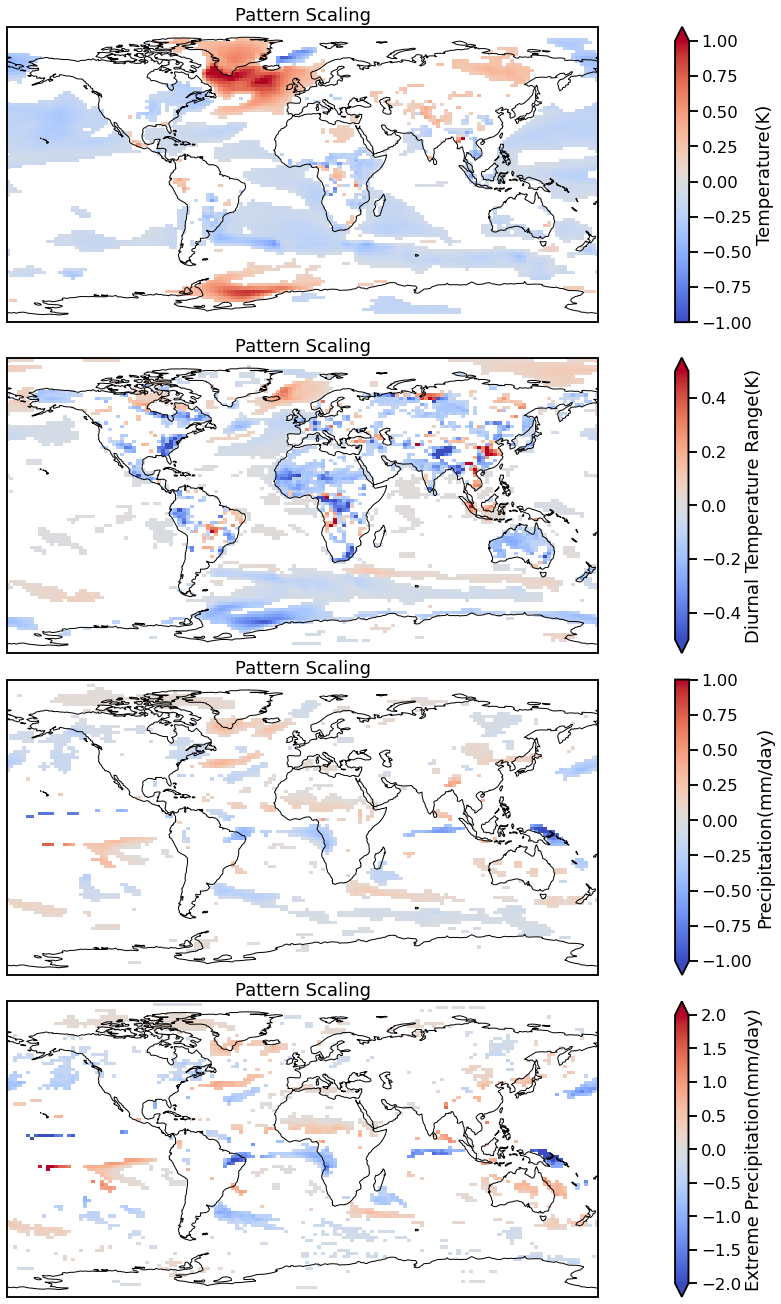

In [14]:
with sns.plotting_context("talk"):
    fig, axes = plt.subplots(4, 1, subplot_kw=dict(projection=proj), figsize=(24, 18), constrained_layout=True)
    for i in range(4):
        out = output_vars[i]
        ax = axes[i]
        diff = xr_output[out][-21:] - ytest[out][-21:]
        kws = kwargs[i]
        label = labels[i]
        
        ax.set_title('Pattern Scaling')
        mean_diff = diff.mean('time')
        _, p = ttest_rel_from_stats(mean_diff, diff.std('time'), diff.count('time'))
        
        
        (mean_diff.where(p < p_level)
                  .plot(
                     cmap="coolwarm", 
                     ax=ax, 
                     add_labels=False, 
                     transform=ccrs.PlateCarree(), 
                     cbar_kwargs={"label":label, "orientation":'vertical'}, 
                     **kws))
        ax.coastlines()